# Deep Neural Network on FPGA: Classifying particle jets 

Credits: [hls4ml tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial)
Materials are used 

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2025-01-28 03:36:44.929471: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 03:36:44.933268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 03:36:44.970370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 03:36:44.970410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 03:36:44.970450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Section 1: Dataset

### 1.1 Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

### 1.2 Visualize the Dataset

In [3]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

#### Input Variables:

- Many of these variables are energy correlation functions $N$, $M$, $C$, and $D$ ([1305.0007](https://arxiv.org/pdf/1305.0007.pdf), [1609.07483](https://arxiv.org/pdf/1609.07483.pdf)). 
- The others are the jet mass (computed with modified mass drop) $m_\mathrm{mMDT}$, $\sum z\\log z$ where the sum is over the particles in the jet,
- $z$ is the fraction of jet momentum carried by a given particle,
- the overall multiplicity of particles in the jet.

#### Lets plot the input variables

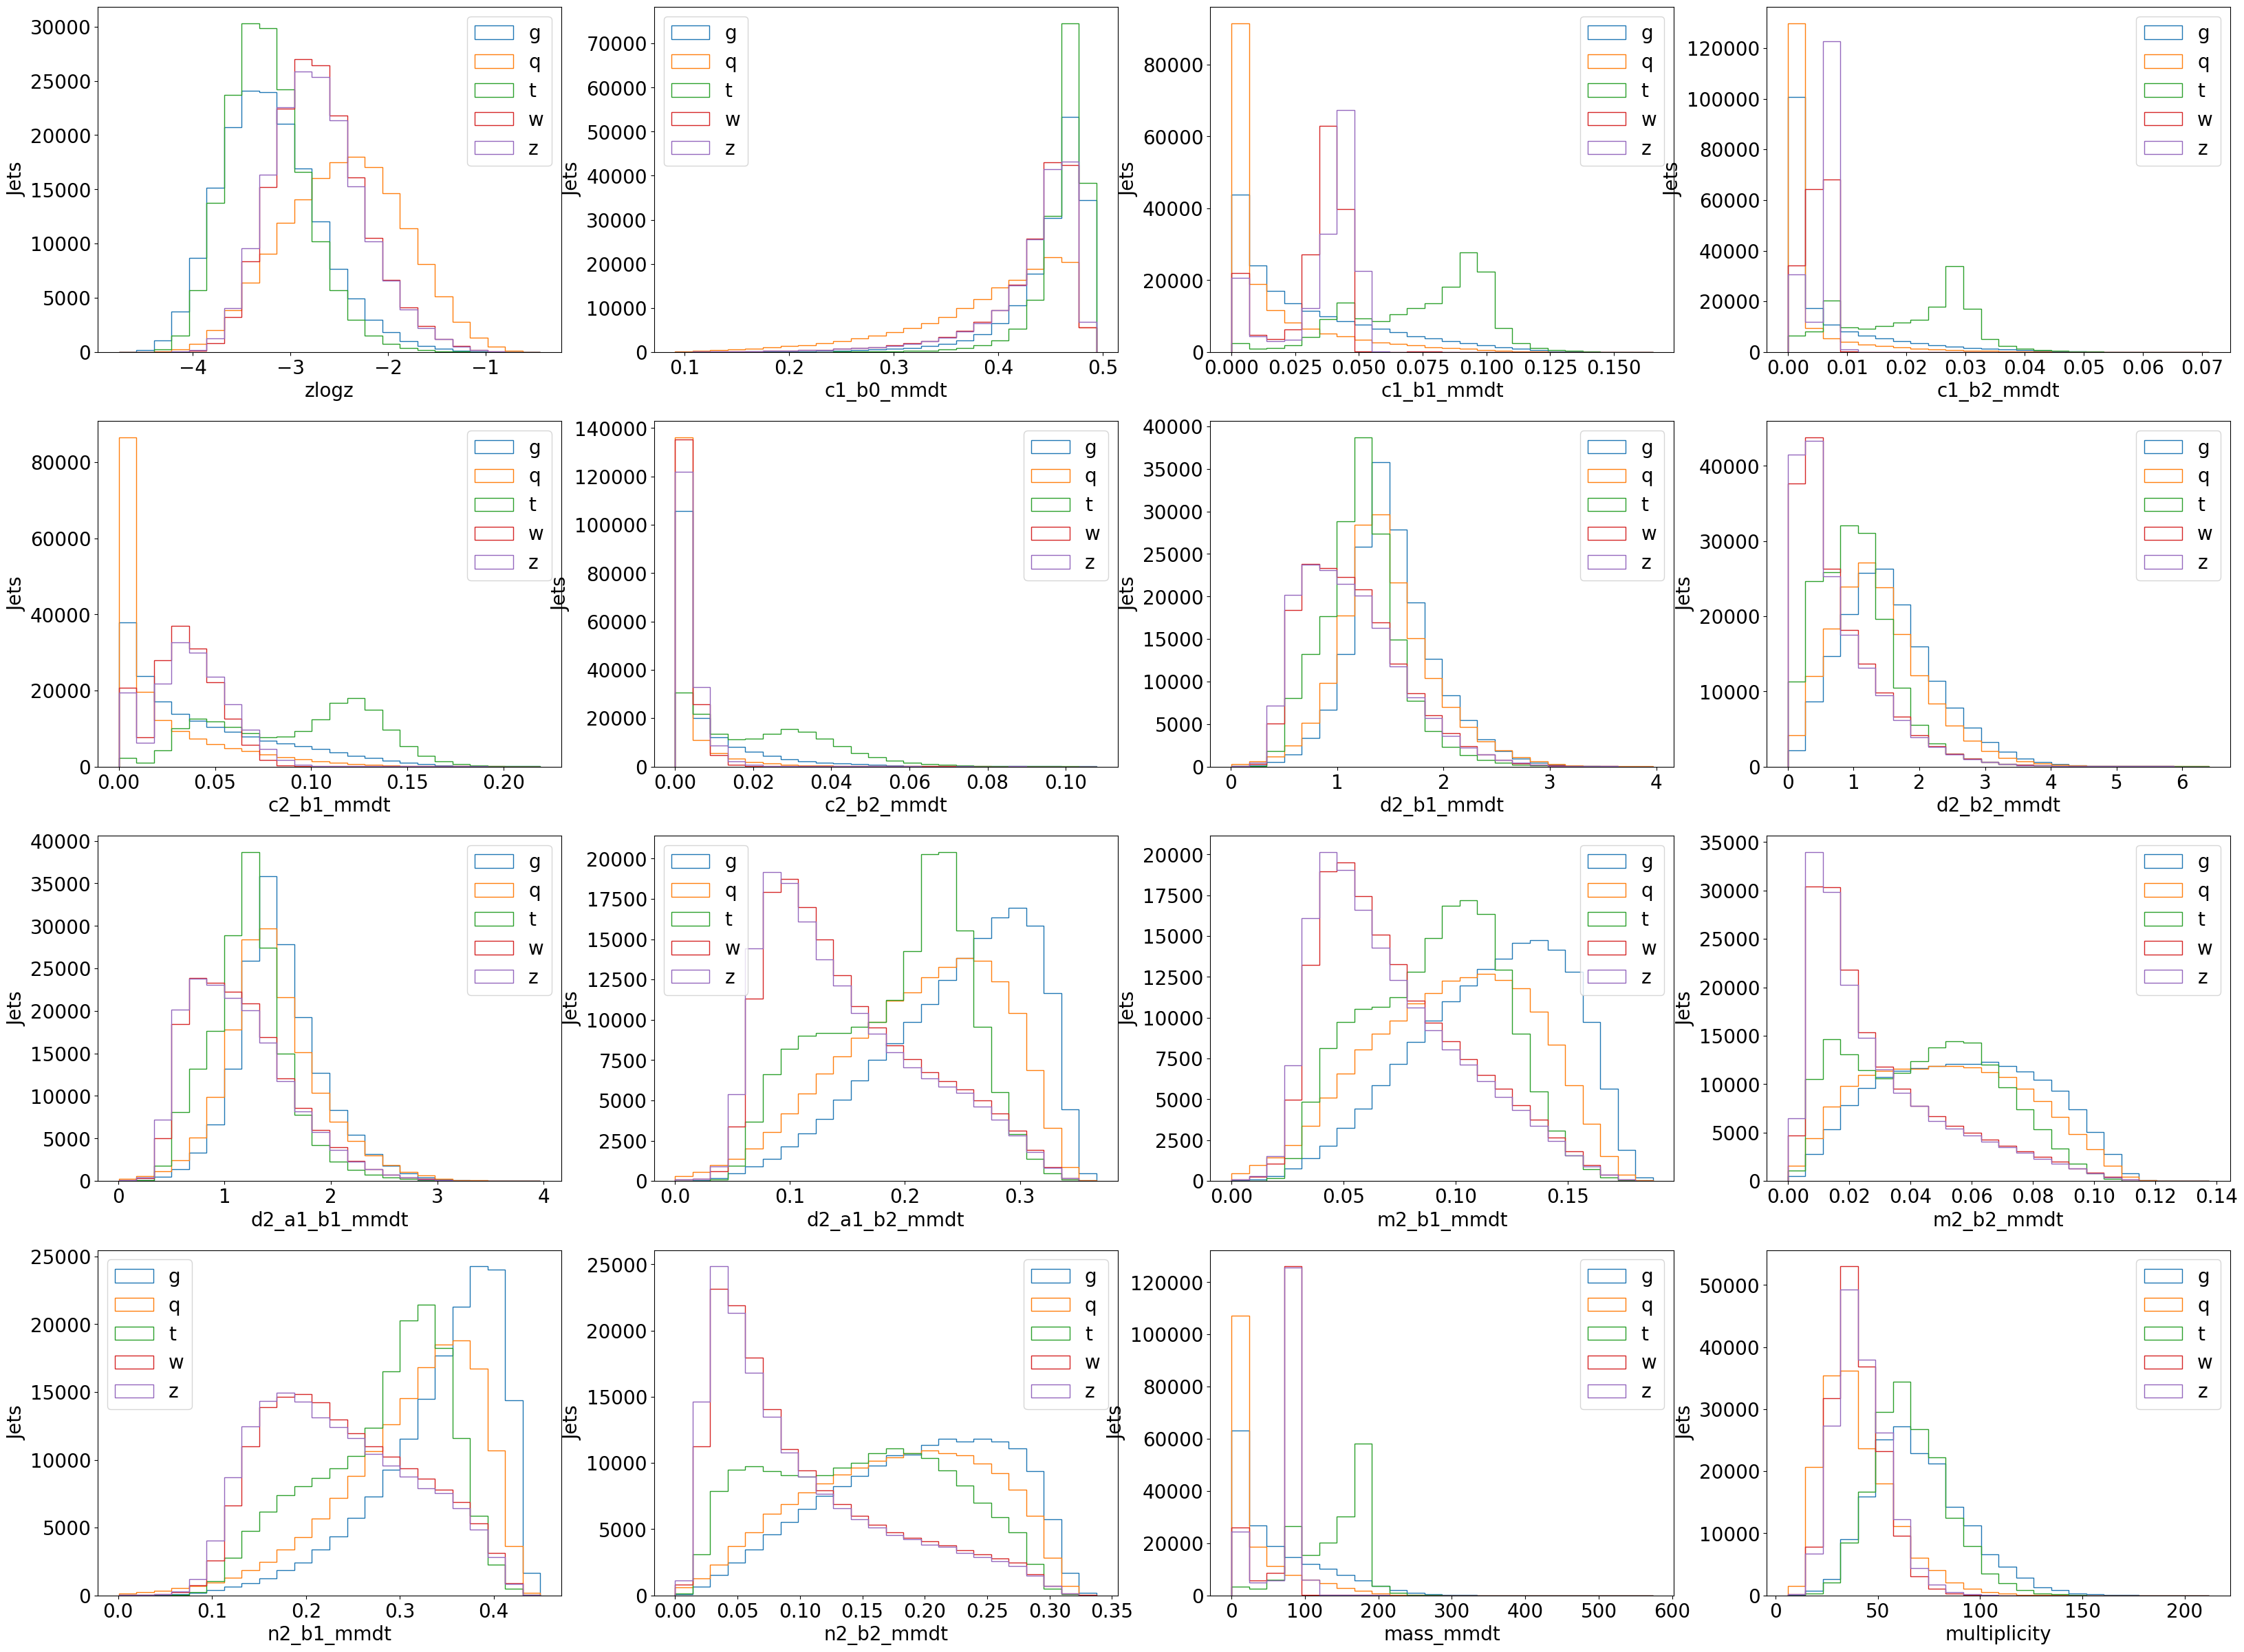

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 30))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 25)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
#plt.tight_layout()
plt.show()

#### Target Variables: 

As you see above, the `y` target is an array of strings, e.g. `["g", "w", ...]` etc. These correspond to different source particles for the jets. You will notice that except for quark- and gluon-initiated jets (`"g"`), all other jets in the dataset have at least one “prong.”

<img src= "images/jet_classes.png" alt="jet_classes" width="600"/>

As the `y` target is an array of strings, e.g. `[\"g\", \"w\", ...]`, we need to make this a \"one-hot\" encoding for the training.
Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


### 1.3 Let's Normalize the training and testing data

In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

#### We will save the training+validation and testing dataset in `npy` format

In [7]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Section 2: Construct a TensorFlow DNN Model

We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

### 2.1 Define the architecture

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [8]:
model = Sequential(name="Sequential: DNN")
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

#### Print the model summary

In [9]:
model.summary()

Model: "Sequential: DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                1088      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)             

## 2.2 Train the model

We'll use Adam optimizer with `categorical crossentropy` loss. The callbacks will decay the learning rate and save the model into a directory 'model_1' The model isn't very complex, so this should just take a few minutes even on the CPU. If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [11]:
train = True
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
481/487 [============================>.] - ETA: 0s - loss: 0.7544 - accuracy: 0.7527  
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.75927, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.75927, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7544 - accuracy: 0.7527 - val_loss: 0.7593 - val_accuracy: 0.7514 - lr: 1.0000e-04
Epoch 2/30
 87/487 [====>.........................] - ETA: 0s - loss: 0.7540 - accuracy: 0.7533

/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


485/487 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.7532
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.75927 to 0.75791, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.75927 to 0.75791, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7531 - accuracy: 0.7532 - val_loss: 0.7579 - val_accuracy: 0.7516 - lr: 1.0000e-04
Epoch 3/30
483/487 [============================>.] - ETA: 0s - loss: 0.7518 - accuracy: 0.7532
***callbacks***
saving losses to model_1/losses.log

Epoch 3: val_loss improved from 0.75791 to 0.75672, saving model to model_1/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.75791 to 0.75672, saving model to model_1/KERAS_check_best_model_

In [16]:
from plotting import makeRoc, plot_confusion_matrix
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.7579759036144579


<Figure size 500x500 with 0 Axes>

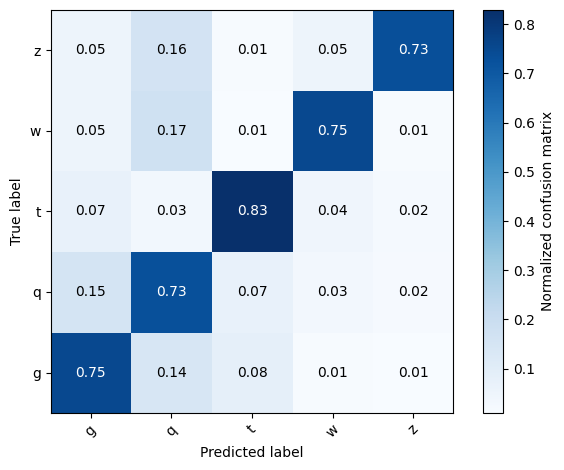

In [13]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

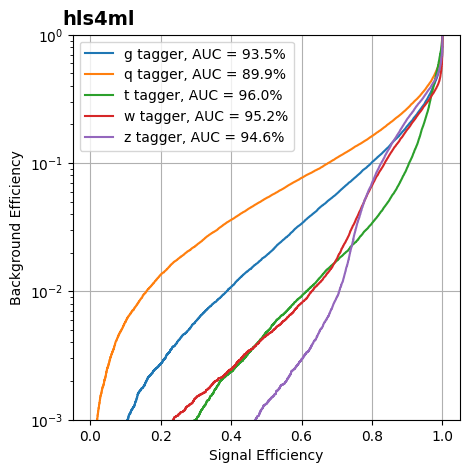

In [14]:
plt.figure(figsize=(5,5))
_ = makeRoc(y_test, y_keras, le.classes_)